<a href="https://colab.research.google.com/github/pravali96/Artificial-Neural-Networks/blob/main/Air_Quality_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
!pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
from google.colab import files
uploaded=files.upload()
import io

Saving air_quality.csv to air_quality (2).csv


In [ ]:
df=pd.read_csv('air_quality.csv')

In [ ]:
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [ ]:
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [ ]:
df=df.dropna()

In [ ]:
y=df.iloc[:,-1]
X=df.iloc[:,:-1]

In [ ]:
# Creating Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers',2,20)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  model.add(keras.layers.Dense(1, activation='linear'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

  return model

In [ ]:
from keras_tuner import RandomSearch
tuner = RandomSearch(
    model_builder,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Air Quality Index')

INFO:tensorflow:Reloading Oracle from existing project project/Air Quality Index/oracle.json
INFO:tensorflow:Reloading Tuner from project/Air Quality Index/tuner0.json


In [ ]:
tuner.search_space_summary

<bound method BaseTuner.search_space_summary of <keras_tuner.tuners.randomsearch.RandomSearch object at 0x7f1efc401150>>

In [ ]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/Air Quality Index
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 17
units_0: 128
units_1: 416
learning_rate: 0.001
units_2: 224
units_3: 448
units_4: 320
units_5: 416
units_6: 512
units_7: 320
units_8: 64
units_9: 320
units_10: 256
units_11: 160
units_12: 448
units_13: 320
units_14: 512
units_15: 64
units_16: 32
Score: 35.00788243611654
Trial summary
Hyperparameters:
num_layers: 4
units_0: 416
units_1: 416
learning_rate: 0.001
units_2: 32
units_3: 32
Score: 41.79108428955078
Trial summary
Hyperparameters:
num_layers: 9
units_0: 448
units_1: 320
learning_rate: 0.0001
units_2: 64
units_3: 512
units_4: 480
units_5: 32
units_6: 224
units_7: 128
units_8: 224
units_9: 224
units_10: 352
units_11: 64
units_12: 416
units_13: 32
units_14: 96
units_15: 352
units_16: 448
Score: 46.44004821777344
Trial summary
Hyperparameters:
num_layers: 16
units_0: 192
units_1: 352
learning_rate: 0.000

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 8ms/step - loss: 34.4206 - mean_absolute_error: 34.4206


In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 416)               53664     
_________________________________________________________________
dense_2 (Dense)              (None, 224)               93408     
_________________________________________________________________
dense_3 (Dense)              (None, 448)               100800    
_________________________________________________________________
dense_4 (Dense)              (None, 320)               143680    
_________________________________________________________________
dense_5 (Dense)              (None, 416)               133536    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2

In [ ]:
model_hist=best_model.fit(X_train, y_train, validation_split=0.2, epochs=200, initial_epoch=5)

Epoch 6/200
22/22 [==============================] - 2s 26ms/step - loss: 35.3599 - mean_absolute_error: 35.3599 - val_loss: 40.4892 - val_mean_absolute_error: 40.4892
Epoch 7/200
22/22 [==============================] - 1s 26ms/step - loss: 33.3601 - mean_absolute_error: 33.3601 - val_loss: 37.8190 - val_mean_absolute_error: 37.8190
Epoch 8/200
22/22 [==============================] - 1s 24ms/step - loss: 34.9237 - mean_absolute_error: 34.9237 - val_loss: 39.6538 - val_mean_absolute_error: 39.6538
Epoch 9/200
22/22 [==============================] - 1s 24ms/step - loss: 37.3440 - mean_absolute_error: 37.3440 - val_loss: 48.5649 - val_mean_absolute_error: 48.5649
Epoch 10/200
22/22 [==============================] - 1s 24ms/step - loss: 35.1027 - mean_absolute_error: 35.1027 - val_loss: 37.9327 - val_mean_absolute_error: 37.9327
Epoch 11/200
22/22 [==============================] - 1s 25ms/step - loss: 34.3867 - mean_absolute_error: 34.3867 - val_loss: 48.2592 - val_mean_absolute_error

In [ ]:
y_pred=best_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

19.65605088462387

In [ ]:
print(model_hist.history.keys())


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


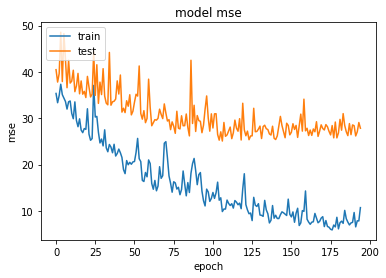

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_hist.history['mean_absolute_error'])
plt.plot(model_hist.history['val_mean_absolute_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

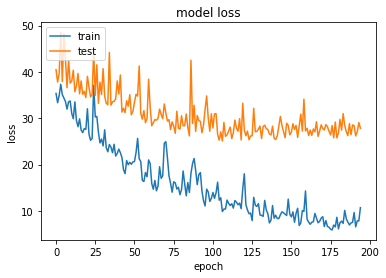

In [ ]:
#Loss function
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#loss decreases until the 100 epochs and then starts increasing for test_set